# CS 109A/AC 209A/STAT 121A Data Science: Airbnb Project
## Step 5 - Seasonal Model
**Harvard University**  
**Fall 2016**  
**Team**: Stephen Camera-Murray, Himani Garg, and Vijay Thangella  
**TF**: Christine Hwang  
  
**Due Date: ** Wednesday, December 14th, 2016 at 11:59pm

### Further Exploration of Seasonality

Import libraries

In [20]:
# import libraries
import warnings
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import random
from sklearn.linear_model import LogisticRegression
import wordcloud
import pandasql
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DecisionTree
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV

# suppress warnings
warnings.filterwarnings ( 'ignore' )
%matplotlib inline

#### Load the cleansed data

We begin by loading the listings dataset we saved after cleansing from milestone #4:  
- cleansed_listings.csv.gz - the New York City Airbnb listing data from January 2015 (cleansed)
- calendar.csv.gz - listing prices for specific dates-- to be analyzed for seasonality

In [2]:
# load listings data into a pandas df
listingsDF = pd.read_csv (  './datasets/cleansed_listings_with_target.tab.gz', sep = '\t', index_col = 'id', compression = 'gzip' )

# display the first two rows
listingsDF.head ( n = 2 )

,name,neighborhood,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,square_feet,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,host_listing_count,months_as_host,months_since_first_review,months_since_last_review,price_category
id,,,,,,,,,,,,,,,,,,,,,
1069266,Stay like a real New Yorker!,Midtown East,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,1.0,...,7.0,9.0,9.0,10.0,9.0,1,21,21,1,Mid
2061725,Option of 2 Beds w Private Bathroom,Bushwick,Apartment,Private room,2,1.0,1.0,2.0,Real Bed,1.0,...,10.0,10.0,10.0,9.0,10.0,4,24,11,1,Low


In [3]:
listingsDF.shape

(19526, 30)

In [4]:
# load listings data into a pandas df
calendarDF = pd.read_csv (  './datasets/cleansed_calendar.tab.gz', sep = '\t', compression = 'gzip' )

# display the first two rows
calendarDF.head ( n = 2 )

,listing_id,date,available,price,month,season
0,3604481,2015-01-01,t,600.0,1,Winter
1,3604481,2015-01-02,t,600.0,1,Winter


In [5]:
calendarDF.shape

(7201883, 6)

#### Visualize Seasonality Trends

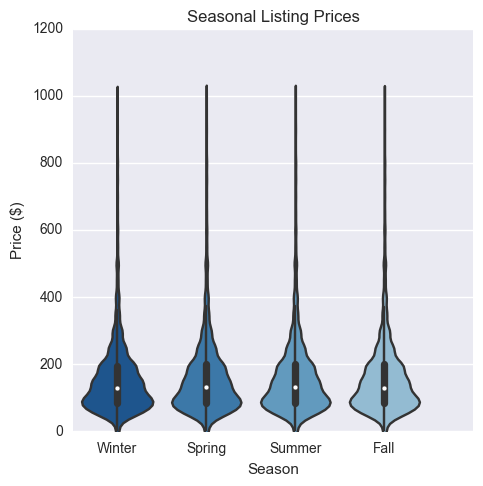

In [6]:
# create a seasonal dataframe with average seasonal pricing for each listing
seasonalDF = calendarDF.groupby ( [ 'listing_id', 'season' ] ) [ 'price' ].mean().to_frame ( name = 'price' ).reset_index()

# parse out the seasonal pricing data
seasons = [ "Winter", "Spring", "Summer", "Fall" ]
df = [ seasonalDF [ "price" ][ ( seasonalDF [ "season" ] == season ) ].values for season in seasons ]

# set up our visualization
sns.set ( rc = { "figure.figsize" : ( 5, 5 ) } )
sns.set_palette ( palette = "Blues_r" )

# create violin plot
ax = sns.violinplot ( data = df )

# set labels
ax.set_title  ( "Seasonal Listing Prices" )
ax.yaxis.grid ( True )
ax.set_xticks ( [ ( y + 1 ) for y in range ( len ( df ) ) ] )
ax.set_xlabel ( "Season" )
ax.set_ylabel ( "Price ($)" )

# add x-tick labels and adjust y-axis
plt.setp (ax, xticks = [ ( y ) for y in range ( len ( df ) ) ], xticklabels = seasons )
ax.set ( ylim = ( 0, None ) )

# display plot
plt.tight_layout()
plt.show()

We didn’t find any significant seasonality effect on price when looking strictly at the calendar seasons. But we did see price fluctuations and will explore further what might be causing them by looking at other seasonal effects such as holidays, back-to-school, or summer to see if there's a real effect. We'll delve deeper into the potential for seasonal effects from a holiday perspective and/or through interactions (e.g. higher prices around the holidays to accommodate friends and relatives).

#### Visualize Seasonality Trends  Further
Let's start by only looking at 2015 since we have a few dates in 2016 and some prices that are 0-- we'll filter those out.

In [7]:
# filter out 2016 dates from the calendar listings
calendarDF = calendarDF [ ( calendarDF [ "date" ] < "2016-01-01" ) & ( calendarDF [ "price" ] > 0 ) ]

Next, we'll get the baseline price for each listing, then append it to our original dataset. We'll also get the neighborhood using an inner join which will filter our calendar dataset to one bedroom units as well.

In [8]:
# get the baseline price based on the mode
baselineDF = calendarDF.groupby ( [ 'listing_id' ] ) [ 'price' ].agg (
    lambda x : x.value_counts().index [ 0 ] ).to_frame ( name = 'baseline_price' ).reset_index()

# now add the baseline price to the dataframe
calendarDF = calendarDF.join ( baselineDF.set_index ( "listing_id" ), on = "listing_id" )

# add the neighborhood to the dataframe as well
calendarDF = calendarDF.join ( listingsDF [ [ "neighborhood" ] ], on = "listing_id", how = "inner" )

Now, add the price delta and price delta percent to the dataframe and remove listing dates without a price difference.

In [9]:
# add the price_delta and price_delta_pct
calendarDF [ "price_delta" ]     = ( calendarDF [ "price" ] - calendarDF [ "baseline_price" ] )
calendarDF [ "price_delta_pct" ] = ( 100.0 * ( calendarDF [ "price" ] - calendarDF [ "baseline_price" ] ) / calendarDF [ "baseline_price" ] )

# remove listing dates without a price difference
calendarDF = calendarDF [ calendarDF [ "price_delta_pct" ] != 0 ]

Next, calculate the mean price delta percentage by date and visualize it so we can see if there are any obvious trends.

In [10]:
# get the mean price delta 
pricechangeDF = calendarDF.groupby ( [ 'date' ] ) [ 'price_delta_pct' ].mean().to_frame ( name = 'mean_pct_price_change' ).reset_index()

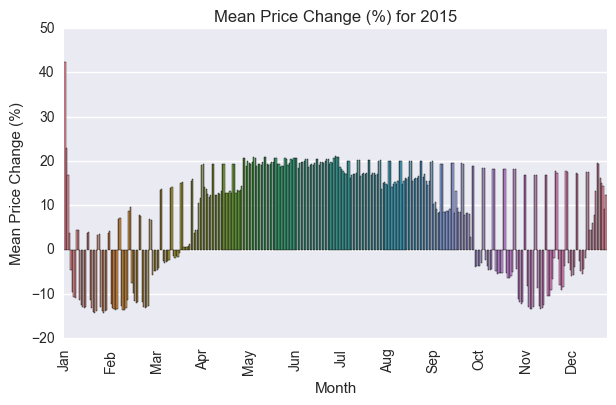

In [11]:
# set up visualization
sns.set ( rc = { "figure.figsize" : ( 7, 4 ) } )

# plot the histogram of prices - filtering out the extreme highs
ax = sns.barplot ( x = "date", y = "mean_pct_price_change", data = pricechangeDF )

# set the labels
ax.set_title  ( "Mean Price Change (%) for 2015" )
ax.set_xlabel ( "Month" )
ax.set_ylabel ( "Mean Price Change (%)" )
ax.xaxis.set_ticks ( np.arange ( 0, 365, 31 ) )
ax.set_xticklabels ( np.array ( [ 'Jan', 'Feb', 'Mar', 'Apr', 'May'
                                , 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec' ] ), rotation = 90 )

# display the visualization
plt.show()

There are a few seasonality differences we can easily spot from our visualization:
- weekends tend to command a higher price than weekdays
- fall and winter generally have discounted prices compared to spring and summer
- the Christmas and New Years holidays are usually more expensive

Another thing we notice is there seems to be a pattern to the average percent change in price that we might be able to bucket naturally. Again, the reason we choose to go this route is user-friendliness for sellers and buyers in the UI. Let's look at a distribution plot of percent price differences.

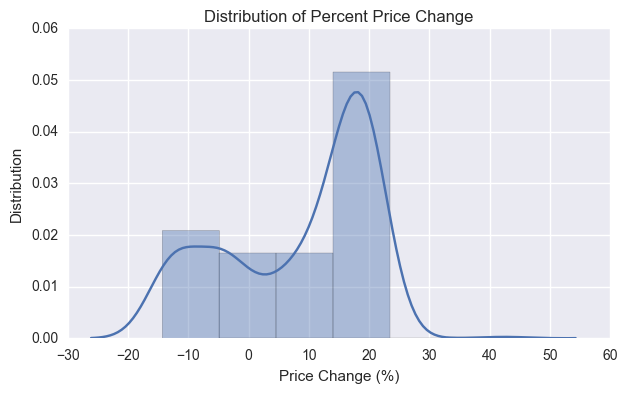

In [12]:
# set up visualization
sns.set ( rc = { "figure.figsize" : ( 7, 4 ) } )

# plot the histogram of percent price differences
ax = sns.distplot ( pricechangeDF [ "mean_pct_price_change" ], bins = 6 )

# set the labels
ax.set_title  ( "Distribution of Percent Price Change" )
ax.set_xlabel ( "Price Change (%)" )
ax.set_ylabel ( "Distribution" )

#ax.set_xlim ( 0, 1000 )

# display the visualization
plt.show()

From the histogram above, we see that we can create four buckets of percentage price changes which covers the general types of price movements we see throughout the year. In addition, we note on the full year histogram, during the New Year's holiday we have a large spike in price which we'll create a specific bucket for.  
  
From these buckets we'll create a new classifier, price_change_category, to cover the following price changes:
- -10%
- Base Price
- +10%
- +20%
- +40% (New Year's Holiday)

In [13]:
# prepopulate the price_change_category column with "Baseline Price"
pricechangeDF [ "price_change_category" ] = "Baseline Price"

# set the remaining price_change_category columns
pricechangeDF [ "price_change_category" ][   pricechangeDF [ "mean_pct_price_change" ] <= -5   ] = "-10%"
pricechangeDF [ "price_change_category" ][ ( pricechangeDF [ "mean_pct_price_change" ] >=  5 ) &
                                           ( pricechangeDF [ "mean_pct_price_change" ] <  15 ) ] = "+10%"
pricechangeDF [ "price_change_category" ][   pricechangeDF [ "mean_pct_price_change" ] >= 15   ] = "+20%"
pricechangeDF [ "price_change_category" ][   pricechangeDF [ "date" ].str [ 5 : ] <= "01-02"   ] = "+40% (New Year's Holiday)"

To give our model the ability to trend seasonality, we'll add the following date-based features:  
- weekend - 1 for weekend, 0 for weekday
- month - 1-12 for January-December
- new_year_holiday - 1 for New Year's holiday, 0 otherwise
- xmas_holiday - 1 for Christmas holiday, 0 otherwise

In [14]:
# add a weekend indicator to each dataframe
calendarDF    [ "weekend" ] = ( pd.to_datetime (    calendarDF [ "date" ] ).dt.dayofweek >= 5 ) * 1
pricechangeDF [ "weekend" ] = ( pd.to_datetime ( pricechangeDF [ "date" ] ).dt.dayofweek >= 5 ) * 1

# add month feature to each dataframe
calendarDF    [ "month" ] = pd.to_datetime (    calendarDF [ "date" ] ).dt.month
pricechangeDF [ "month" ] = pd.to_datetime ( pricechangeDF [ "date" ] ).dt.month

# add xmas_holiday feature
calendarDF    [ "new_year_holiday" ] = (    calendarDF [ "date" ].str [ 5 : ] <= "01-02" ) * 1
pricechangeDF [ "new_year_holiday" ] = ( pricechangeDF [ "date" ].str [ 5 : ] <= "01-02" ) * 1

# add xmas_holiday feature
calendarDF    [ "xmas_holiday" ] = (    calendarDF [ "date" ].str [ 5 : ] >= "12-24" ) * 1
pricechangeDF [ "xmas_holiday" ] = ( pricechangeDF [ "date" ].str [ 5 : ] >= "12-24" ) * 1

#### Baseline Model
Since we're using a single year to predict seasonal price changes, we must build our model on all of our dates and cannot randomly split our data into train and test, otherwise we might miss the Christmas or New Year's holidays. While some danger of overfitting exists, as long as we know that the year 2015 was a "normal" year (e.g. a major event like the Olympics wasn't held) and we only use the weekend indictor, month, and holiday indicators as predictors, testing the model on the full dataset poses little risk.

Create a function to score our models.

In [15]:
# function to compute the accuracy of a given model
score = lambda model, x_test, y_test: pd.Series ( [ model.score ( x_test, y_test ), 
                                                    model.score ( x_test [ y_test == "-10%" ],  y_test [ y_test == "-10%" ]  ),
                                                    model.score ( x_test [ y_test == "Baseline Price" ],  y_test [ y_test == "Baseline Price" ]  ),
                                                    model.score ( x_test [ y_test == "+10%" ],  y_test [ y_test == "+10%" ]  ),
                                                    model.score ( x_test [ y_test == "+20%" ],  y_test [ y_test == "+20%" ]  ),
                                                    model.score ( x_test [ y_test == "+40% (New Year's Holiday)" ], y_test [ y_test == "+40% (New Year's Holiday)" ] ),
                                                    f1_score    ( y_test, model.predict ( x_test ), average = "weighted" ) ],
                                                    index = [ 'Overall Accuracy', 'Accuracy on -10% Category', 'Accuracy on Baseline Price Category', 'Accuracy on +10% Category', 'Accuracy on +20% Category', 'Accuracy on +40% Category', 'F1 Score'  ])

Create functions for our baseline models.

In [16]:
# model predicting random values
class random_model ( object ):
    def predict ( self, x ):
        cats = [ "-10%", "Baseline Price", "+10%", "+20%", "+40% (New Year's Holiday)" ]
        return np.random.choice ( cats, len ( x ), replace = True )

    def score ( self, x, y ):
        y_pred = self.predict ( x )
        return ( y_pred == y ).sum() * 1. / len ( y )

# model predicting Baseline Price
class baseline_price_model ( object ):
    def predict ( self, x ):
        return np.array ( [ "Baseline Price" ] * len ( x ) )
    def score ( self, x, y ):
        y_pred = self.predict ( x )
        return ( y_pred == y ).sum() * 1. / len ( y )

Build our models and score.

In [17]:
# split out x and y
x = pricechangeDF.drop ( [ 'date', 'mean_pct_price_change', 'price_change_category' ], axis = 1 )
y = pricechangeDF [ "price_change_category" ]

# build and score our baseline models
random                = random_model()
random_model_scores   = score ( random, x, y )

base                  = baseline_price_model()
baseline_price_scores = score ( base, x, y )

# print scores
scoreDF = pd.DataFrame ( { 'Random Model'              : random_model_scores,
                           'Baseline Price Model'      : baseline_price_scores } )
scoreDF

,Baseline Price Model,Random Model
Overall Accuracy,0.156164,0.208219
Accuracy on -10% Category,0.000000,0.250000
Accuracy on Baseline Price Category,1.000000,0.245614
Accuracy on +10% Category,0.000000,0.132353
Accuracy on +20% Category,0.000000,0.210843
Accuracy on +40% Category,0.000000,0.000000
F1 Score,0.042187,0.260211


#### Build an Improved Model

Given that we're treating seasonality the same for all future years, we wish to fit our model only on the features we created so we can adjust for weekends and not fit to dates, except for on holidays. Let's try a few more advanced models to see how they do.

In [57]:
# build and score our more advanced models
qda = QDA()
qda.fit ( x, y )
qda_scores = score ( qda, x, y )

dtree = DecisionTree ()
dtree.fit ( x, y )
tree_scores = score ( dtree, x, y )

knn = KNN ( n_neighbors = 1 )
knn.fit ( x, y )
knn_scores = score ( knn, x, y )

rf = RandomForest ()
rf.fit ( x, y )
rf_scores = score ( rf, x, y )

SVM = SVC ( class_weight = 'balanced' )
SVM.fit ( x, y )
svm_scores = score ( SVM, x, y )

# print scores
scoreDF = pd.DataFrame ( { 'QDA Model'           : qda_scores,
                           'Decision Tree Model' : tree_scores,
                           'KNN Model'           : knn_scores,
                           'Random Forest Model' : rf_scores,
                           'SVM Model'           : svm_scores } )

scoreDF

,Decision Tree Model,KNN Model,QDA Model,Random Forest Model,SVM Model
Overall Accuracy,0.745205,0.663014,0.186301,0.745205,0.676712
Accuracy on -10% Category,0.652778,0.513889,0.000000,0.708333,0.750000
Accuracy on Baseline Price Category,0.754386,0.596491,0.000000,0.754386,0.807018
Accuracy on +10% Category,0.735294,0.411765,1.000000,0.617647,0.779412
Accuracy on +20% Category,0.783133,0.849398,0.000000,0.807229,0.554217
Accuracy on +40% Category,1.000000,1.000000,0.000000,1.000000,1.000000
F1 Score,0.750232,0.655099,0.058515,0.748483,0.685254


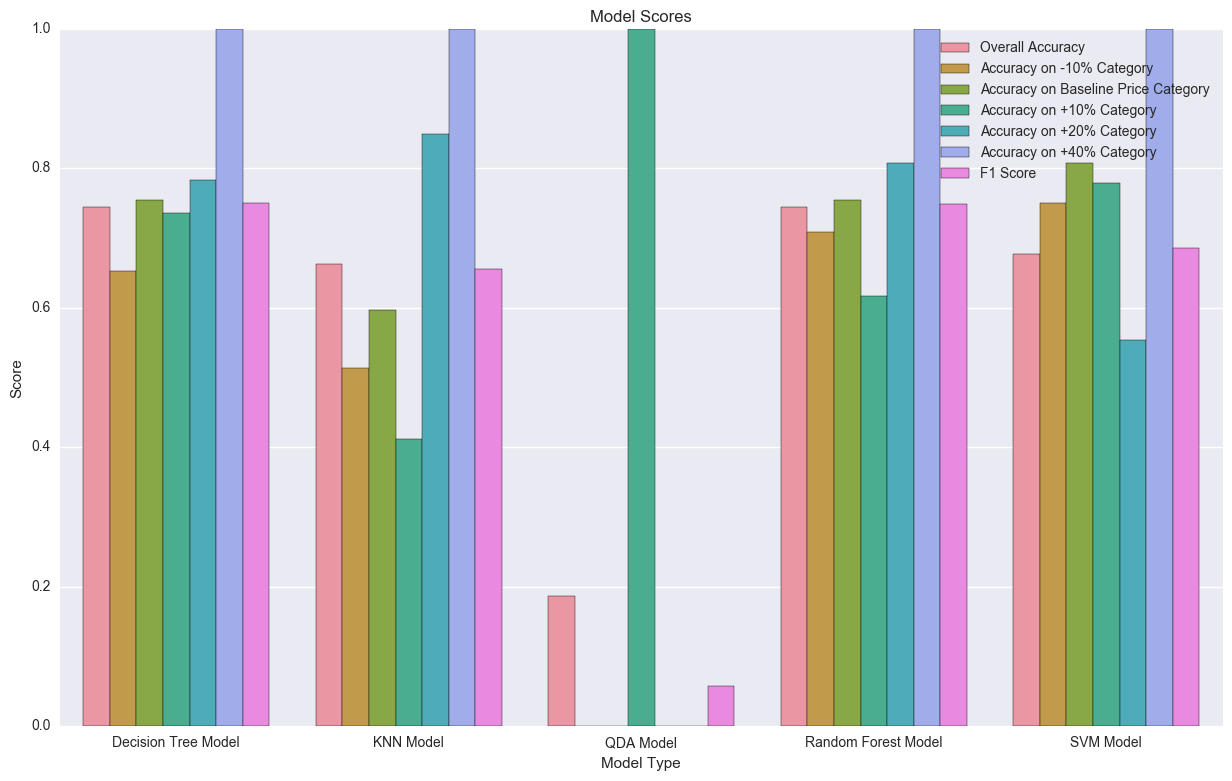

In [66]:
# set up visualization
sns.set ( rc = { "figure.figsize" : ( 15, 9 ) } )
ax = plt.axes()

# reformat the score data so it's friendlier to seaborn
scoreplotDF = pd.concat ( [ pd.DataFrame ( { "Score Type": np.tile ( scoreDF.index.values, 5 ) } ), pd.melt ( scoreDF, var_name = "Model", value_name = "Score" ) ], axis = 1 )

# create a barplot of the price categories
ax = sns.barplot ( x = "Model", y = "Score", hue = "Score Type", data = scoreplotDF )

# set the labels
ax.set_title  ( "Model Scores" )
ax.set_xlabel ( "Model Type" )
ax.set_ylabel ( "Score" )
plt.legend ( loc = 'upper right' )

# display the visualization
plt.show()

The decision tree classifier has the best overall accuracy with the best F1 score, just a bit better than random forest. And because it is less computationally expensive, we'll focus on this model to optimize the model parameters with grid search cross-validation.

In [46]:
# set our gridsearch paramters
parameters = {  "criterion": [ "gini", "entropy" ], "splitter" : [ "best", "random" ], "max_features" : [ 1, 2, 3, 4 ]
               ,"max_depth": [ None, 1, 2, 3, 4, 5, 6 ], "min_samples_split": [ 0.1, 0.3, 0.5, 0.7, 0.8 ]
               ,"min_samples_leaf": [ 0.1, 0.3, 0.5 ], "min_weight_fraction_leaf": [ 0, 0.1, 0.3, 0.5 ]
               ,"max_leaf_nodes": [ None, 2, 3, 4, 5, 6 ] }

# perform the grid search CV and pick the best model using our custom scorer
gs = GridSearchCV ( dtree, param_grid = parameters, n_jobs = 1, scoring = "f1_weighted" )
gs.fit ( x, y )
gs = gs.best_estimator_

# print our cost improvement percentage
print ( 'Improvement over baseline: {0:.3f}' ).format ( score_df [ "Decision Tree Model"].loc [ "F1 Score" ] - f1_score ( y, dtree.predict ( x ), average = "weighted" ) )

Improvement over baseline: 0.000


After applying exhaustive grid search cross-validation, we find that the default decision tree model performs best. This is the model we'll use to recommend price discount categories based on the rental dates.